In [1]:
import yfinance as yf

data = yf.download(tickers = "6E=F", start="2017-12-01", end="2023-06-16", interval='1d')

[*********************100%***********************]  1 of 1 completed


In [2]:
data = data.reset_index('Date', inplace=False)

In [3]:
df = data

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Conv1D, MaxPooling1D, Bidirectional

In [5]:
df1=df.reset_index()['Close']

In [6]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [7]:
# 4. Chia train test
train_size = int(0.7 * len(df1))
test_size = int(0.2 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [8]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [9]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [10]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [11]:
# 8. Define LSTM Model
# Define the model
model = Sequential()

# Add a 1D convolutional layer
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(100,1)))

# Add a max pooling layer
model.add(MaxPooling1D(pool_size=2))

# Add another 1D convolutional layer
model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))

# Add a bidirectional LSTM layer
model.add(Bidirectional(LSTM(100, activation='relu')))

# Add a dense output layer
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [12]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
14/14 [==============================] - 15s 505ms/step - loss: 0.1583 - val_loss: 0.0498
Epoch 2/100
14/14 [==============================] - 3s 252ms/step - loss: 0.0144 - val_loss: 0.0276
Epoch 3/100
14/14 [==============================] - 4s 273ms/step - loss: 0.0065 - val_loss: 0.0291
Epoch 4/100
14/14 [==============================] - 3s 172ms/step - loss: 0.0052 - val_loss: 0.0370
Epoch 5/100
14/14 [==============================] - 3s 184ms/step - loss: 0.0044 - val_loss: 0.0308
Epoch 6/100
14/14 [==============================] - 2s 124ms/step - loss: 0.0039 - val_loss: 0.0260
Epoch 7/100
14/14 [==============================] - 2s 133ms/step - loss: 0.0038 - val_loss: 0.0280
Epoch 8/100
14/14 [==============================] - 2s 130ms/step - loss: 0.0033 - val_loss: 0.0235
Epoch 9/100
14/14 [==============================] - 2s 130ms/step - loss: 0.0031 - val_loss: 0.0221
Epoch 10/100
14/14 [==============================] - 2s 126ms/step - loss: 0.0029 - val_l

In [13]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

2/2 [==============================] - 0s 12ms/step


In [14]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)

In [15]:
ytest = scaler.inverse_transform(ytest.reshape(-1,1))

yval = scaler.inverse_transform(yval.reshape(-1,1))

In [16]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)

Validation RMSE: 0.00513420925435788
Testing RMSE: 0.01425523638719834


In [17]:
from sklearn.metrics import mean_absolute_error
valid_mae = mean_absolute_error(yval, y_pred_val)
test_mae = mean_absolute_error(ytest, y_pred)
print('Validation MAE:', valid_mae)
print('Testing MAE:', test_mae)

Validation MAE: 0.004164640720073993
Testing MAE: 0.011140350880247826


In [18]:
from sklearn.metrics import mean_absolute_percentage_error

In [19]:
valid_mape = mean_absolute_percentage_error(yval, y_pred_val)
test_mape = mean_absolute_percentage_error(ytest, y_pred)
print('Validation MAPE:', valid_rmse)
print('Testing MAPE:', test_rmse)

Validation MAPE: 0.00513420925435788
Testing MAPE: 0.01425523638719834


In [20]:
# 13. Dự báo 30 ngày tiếp theo
x_input=val_data[40:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<30):

    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1

[0.42582068]
101
1 day input [0.45323002 0.4434107  0.43652018 0.42842381 0.43393598 0.47304032
 0.44823411 0.41205856 0.38432397 0.38242894 0.38363479 0.38776902
 0.36537452 0.37553842 0.39379828 0.37364339 0.3758826  0.37812221
 0.36106779 0.34418586 0.34177416 0.32627017 0.34608089 0.33712325
 0.36244614 0.33867328 0.35383268 0.36744163 0.32437556 0.32248053
 0.33212734 0.35503853 0.38105059 0.3958654  0.3433246  0.35073221
 0.37450466 0.3882857  0.40241174 0.44254944 0.42825131 0.40000004
 0.41188606 0.42807922 0.42825131 0.44840661 0.4310076  0.44478906
 0.46425477 0.44806202 0.45564172 0.43049092 0.44702826 0.47700246
 0.49457356 0.47734705 0.45167958 0.47390159 0.46701106 0.47062862
 0.47441867 0.49836321 0.47252365 0.49526274 0.49009475 0.48682178
 0.47045653 0.48079252 0.501292   0.48492675 0.48854431 0.4811367
 0.46735565 0.47062862 0.44995705 0.42739004 0.43617559 0.43944856
 0.42876839 0.4036176  0.41774323 0.4211887  0.40620139 0.39707125
 0.38639108 0.38931946 0.38535732 

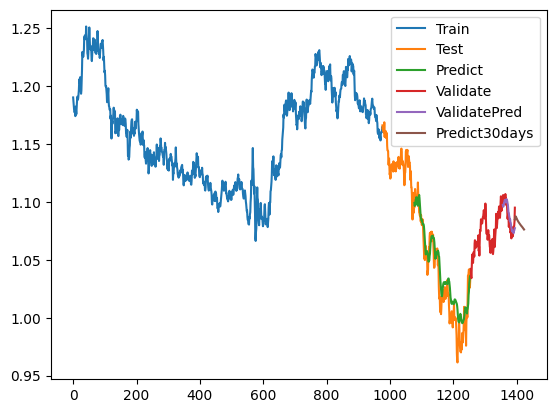

In [21]:
# 14.Vẽ hình

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
plt.show()

In [22]:
scaler.inverse_transform(lst_output)

array([[1.08494448],
       [1.08553292],
       [1.08758819],
       [1.08738515],
       [1.08688006],
       [1.08616758],
       [1.0856613 ],
       [1.08492647],
       [1.08440308],
       [1.08388607],
       [1.08340076],
       [1.08292319],
       [1.0825036 ],
       [1.08207857],
       [1.08172709],
       [1.08127813],
       [1.0809759 ],
       [1.08049239],
       [1.08020426],
       [1.07974009],
       [1.07951387],
       [1.07903469],
       [1.07884318],
       [1.07839424],
       [1.07815926],
       [1.07765106],
       [1.07739858],
       [1.07687418],
       [1.07667331],
       [1.07622942]])